classes = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
super_classes = ['directions', 'commands', 'binary_commands']
directions = left, right, up, down
commands = stop, go
binary_commands = on, off, yes, no

In [1]:
import random
import os
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
warnings.filterwarnings("ignore")
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Sub-class classifier

In [60]:
# create dict for feature extraction
classes =  ['no', 'yes', 'down', 'up', 'left', 'right', 'on', 'off', 'stop', 'go']
parent_dir = ''
file_dict = { 'wav_file' : [], 'class': [], 'fold':[]}

for i in classes:
    class_dir = parent_dir+i
    files = [class_dir + '/' + j for j in os.listdir(class_dir)]
    fold = [random.randint(1,10) for i in range(len(files))]
    file_dict['wav_file'] += files
    file_dict['class'] += [i]*len(files)
    file_dict['fold'] += fold
print(file_dict)
df= pd.DataFrame(file_dict)
print(df)

{'wav_file': ['no/c692524d_nohash_1.wav', 'no/9bea2ac7_nohash_0.wav', 'no/6078eb0d_nohash_1.wav', 'no/1bb574f9_nohash_1.wav', 'no/bbd0bbd0_nohash_4.wav', 'no/2dce72b3_nohash_0.wav', 'no/f6581345_nohash_0.wav', 'no/eb67fcbc_nohash_0.wav', 'no/ac652c60_nohash_0.wav', 'no/afb9e62e_nohash_1.wav', 'no/5c8af87a_nohash_1.wav', 'no/eb3f7d82_nohash_2.wav', 'no/d197e3ae_nohash_2.wav', 'no/3f339c33_nohash_0.wav', 'no/5c39594f_nohash_2.wav', 'no/324210dd_nohash_3.wav', 'no/099d52ad_nohash_4.wav', 'no/c692524d_nohash_0.wav', 'no/4f2ab70c_nohash_1.wav', 'no/686d030b_nohash_1.wav', 'no/40b60ae9_nohash_0.wav', 'no/72320401_nohash_0.wav', 'no/bab36420_nohash_3.wav', 'no/541e4079_nohash_3.wav', 'no/cb8f8307_nohash_0.wav', 'no/cb8f8307_nohash_1.wav', 'no/2e0d80f7_nohash_2.wav', 'no/6c429c7b_nohash_2.wav', 'no/66cbe2b3_nohash_1.wav', 'no/dca2797e_nohash_4.wav', 'no/a97017df_nohash_1.wav', 'no/c518d1b1_nohash_0.wav', 'no/9aa21fa9_nohash_3.wav', 'no/af405b69_nohash_0.wav', 'no/cd7f8c1b_nohash_4.wav', 'no/29

In [61]:
# extract mel spectrograms
def extract_melspectrogram(wavpath, sample_rate=16000):
    sample_rate = 16000
    window_size = .025
    window_stride = 0.01
    n_dft = 512
    win_length = int(sample_rate * window_size)
    hop_length = int(sample_rate * window_stride)
    y, sr = librosa.load(wavpath, sr=sample_rate)
    y = y - y.mean()
    y = np.append(y[0],y[1:]-.97*y[:-1])
    # compute mel spectrogram
    stft = librosa.stft(y, n_fft=n_dft, hop_length=hop_length,
        win_length=win_length, window=scipy.signal.hamming)
    spec = np.abs(stft)**2
    mel_basis = librosa.filters.mel(sr=sample_rate, n_fft=n_dft, n_mels=40, fmin=20)
    melspec = np.dot(mel_basis, spec)
    logspec = librosa.power_to_db(melspec, ref=np.max)
    logspec = np.transpose(logspec)
    if (logspec.shape[0] != 101): #zero pad short utterances
        zero_pad = np.zeros((101-logspec.shape[0], 40),dtype=np.float32)
        logspec= np.vstack((logspec,zero_pad))
    return logspec

In [69]:
# calculate mel spectrograms of each wav file
features=[]
labels=[]
folds=[]
sr=16000
for i in range(len(df)):
    fold=df["fold"].iloc[i]
    path=df["wav_file"].iloc[i]
    label = df["class"].iloc[i]
    mfccs = extract_melspectrogram(path, sr)
    features.append(mfccs)
    folds.append(fold)
    labels.append(label)
# encodel categorical labels
le = LabelEncoder()
labels = le.fit_transform(labels)
encoded = labels
features=torch.tensor(features)
labels=torch.tensor(labels)
folds=torch.tensor(folds)
# Saving the dataset to disk to prevent re-Loading
#torch.save(features, "model_outputs/all_features_mfccs.pt")
#torch.save(labels, "model_outputs/all_labels.pt")
#torch.save(folds, "model_outputs/all_folds.pt")

In [79]:
le.inverse_transform(list(set(encoded))), set(encoded)
# left(2), right(6), up(8), down(0) -> 0
# stop(7), go(1) -> 3
# on(5), off(4), yes(9), no(3) -> 6
converter_dict={0: 0,1: 3,2: 0,3: 6,4: 6,5: 6,6: 0,7: 3,8: 0,9: 6}


In [80]:
# START RUNNING CODE HERE (for classifier on 10 classes)
# load dataset for subclass classifier
features=torch.load("model_outputs/all_features_mfccs.pt")#.to(device)
labels=torch.load("model_outputs/all_labels.pt")#.to(device)
folds=torch.load("model_outputs/all_folds.pt")#.to(device)

In [81]:
# omit test fold from dataset
def get_dataset(skip_fold):
    local_features=[]
    local_labels=[]
    for i in range(len(folds)):
        #if folds[i]==skip_fold:
        #    continue
        local_features.append(features[i])
        local_labels.append(labels[i])
    local_features=torch.stack(local_features)
    local_labels=torch.stack(local_labels)
    print("Entire dataset size: ", local_features.size())
    return TensorDataset(local_features, local_labels)

In [82]:
# initialize dataset
dataset=get_dataset(skip_fold=10)
# split data into training and validation sets
val_size=int(0.1*len(dataset))
train_size=len(dataset)-val_size
train_ds, val_ds=random_split(dataset, [train_size, val_size])
print("Number of training samples: ", len(train_ds))
print("Number of validation samples: ", len(val_ds))

# initialize data loader
batch_size=128
train_loader=DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader=DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

Entire dataset size:  torch.Size([23682, 101, 40])
Number of training samples:  21314
Number of validation samples:  2368


In [83]:
# convert data loader back to dataset
x_train, y_train, x_test, y_test = [], [], [], []
for data, labels in train_loader:
    x_train.append(data)
    # print(list(data))
    y_train.append(labels)

x_train = torch.cat(x_train, dim=0)
y_train = torch.cat(y_train, dim=0)
# y_train = torch.tensor(y_train)

for data, labels in val_loader:
    x_test.append(data)
    # print(data.unsqueeze(1))
    y_test.append(labels)

x_test = torch.cat(x_test, dim=0)
y_test = torch.cat(y_test, dim=0)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([21314, 101, 40]) torch.Size([21314])
torch.Size([2368, 101, 40]) torch.Size([2368])


In [84]:
# map 10 class labels to 3 classes
#converter_dict={0: 0,1: 0,2: 0,3: 3,4: 3,5: 3,6: 6,7: 6,8: 6,9: 6}
train_converted_data=np.ones(np.shape(train_ds), dtype=int)*-1
print(train_converted_data)

val_converted_data=np.ones(np.shape(val_ds), dtype=int)*-1
print(val_converted_data)

[[-1 -1]
 [-1 -1]
 [-1 -1]
 ...
 [-1 -1]
 [-1 -1]
 [-1 -1]]
[[-1 -1]
 [-1 -1]
 [-1 -1]
 ...
 [-1 -1]
 [-1 -1]
 [-1 -1]]


In [85]:
for i in range(10):
    train_converted_data[y_train == i] = converter_dict[i]
train_converted_data=(torch.tensor(train_converted_data[:,0])).type(torch.LongTensor)
print(train_converted_data)

for i in range(10):
    val_converted_data[y_test == i] = converter_dict[i]
val_converted_data=(torch.tensor(val_converted_data[:, 0])).type(torch.LongTensor)
print(val_converted_data)

train_ds = TensorDataset(x_train, train_converted_data)
train_dl = DataLoader(train_ds, batch_size=batch_size * 2)

print(x_test.shape, val_converted_data.shape)
test_ds = TensorDataset(x_test, val_converted_data)
test_dl = DataLoader(test_ds, batch_size=batch_size * 2)

tensor([3, 3, 3,  ..., 3, 0, 6])
tensor([0, 6, 0,  ..., 0, 0, 6])
torch.Size([2368, 101, 40]) torch.Size([2368])


In [86]:
# define model
output_size = 10
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        # Model with two CNN layers followed by two fully-connected layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(16 * 1000, 64)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# verify model shape and dimensions will work with input data   
#model = MyModel()
#print(model)
#input = torch.randn(128, 1, 101, 40)
#model(input)
#print(model(input).shape)

In [87]:
# Training loop
def train_network(model, train_loader, criterion, optimizer, start_epoch, end_epoch):
    for epoch in range(start_epoch, end_epoch):
        # Calculate accuracy of this training epoch
        acc, correct, total = 0, 0 ,0
        for i, (inputs, labels) in enumerate(train_loader, 0):
            labels = torch.tensor(labels)
            optimizer.zero_grad()
            inputs = inputs.unsqueeze(1)#.to('cuda')
            #labels = labels.to('cuda')
            outputs = model(inputs)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            acc = correct / total
        print("Epoch %d: training model accuracy %.2f%%" % (epoch, acc*100))
        
# Test model
def test_network(model, val_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs =inputs.unsqueeze(1)#.to('cuda')
            #labels = labels.to('cuda')
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Test accuracy: %d %%' % (100 * correct / total))

In [88]:
# Train model from scratch
# Instantiate the model, loss function, and optimizer
model = MyModel()
#model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
start_epoch = 0
end_epoch = 50
train_network(model, train_dl, criterion, optimizer, start_epoch, end_epoch)
test_network(model, test_dl)


Epoch 0: training model accuracy 40.98%
Epoch 1: training model accuracy 49.38%
Epoch 2: training model accuracy 56.97%
Epoch 3: training model accuracy 64.30%
Epoch 4: training model accuracy 68.42%
Epoch 5: training model accuracy 71.34%
Epoch 6: training model accuracy 74.15%
Epoch 7: training model accuracy 76.34%
Epoch 8: training model accuracy 78.45%
Epoch 9: training model accuracy 80.37%
Epoch 10: training model accuracy 81.78%
Epoch 11: training model accuracy 83.40%
Epoch 12: training model accuracy 84.29%
Epoch 13: training model accuracy 85.13%
Epoch 14: training model accuracy 86.27%
Epoch 15: training model accuracy 87.50%
Epoch 16: training model accuracy 88.42%
Epoch 17: training model accuracy 89.30%
Epoch 18: training model accuracy 89.77%
Epoch 19: training model accuracy 90.50%
Epoch 20: training model accuracy 90.77%
Epoch 21: training model accuracy 90.43%
Epoch 22: training model accuracy 90.84%
Epoch 23: training model accuracy 91.77%
Epoch 24: training model a

In [89]:
# save checkpoint
EPOCH = end_epoch
PATH = "model_outputs/before_drift_model.pt"

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, PATH)

In [90]:
PATH = "model_outputs/before_drift_model.pt"
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
start_epoch = 50
end_epoch = 100
train_network(model, train_loader, criterion, optimizer, start_epoch, end_epoch)
test_network(model, val_loader)

Epoch 50: training model accuracy 26.39%
Epoch 51: training model accuracy 58.91%
Epoch 52: training model accuracy 70.13%
Epoch 53: training model accuracy 75.49%
Epoch 54: training model accuracy 78.49%
Epoch 55: training model accuracy 80.31%
Epoch 56: training model accuracy 81.78%
Epoch 57: training model accuracy 82.76%
Epoch 58: training model accuracy 84.41%
Epoch 59: training model accuracy 84.71%
Epoch 60: training model accuracy 86.45%
Epoch 61: training model accuracy 86.91%
Epoch 62: training model accuracy 87.87%
Epoch 63: training model accuracy 88.33%
Epoch 64: training model accuracy 89.08%
Epoch 65: training model accuracy 89.96%
Epoch 66: training model accuracy 90.52%
Epoch 67: training model accuracy 91.18%
Epoch 68: training model accuracy 91.66%
Epoch 69: training model accuracy 92.31%
Epoch 70: training model accuracy 92.60%
Epoch 71: training model accuracy 93.05%
Epoch 72: training model accuracy 93.45%
Epoch 73: training model accuracy 94.31%
Epoch 74: traini

In [91]:
# save checkpoint
EPOCH = end_epoch
PATH = "model_outputs/after_drift_model.pt"

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, PATH)

In [ ]:
# Train model from checkpoint super-class classifier (originally trained for 3 classes)
# load features for super class dataset
features=torch.load("model_outputs/super_class_all_features_mfccs.pt")#.to(device)
labels=torch.load("model_outputs/super_class_all_labels.pt")#.to(device)
folds=torch.load("model_outputs/super_class_all_folds.pt")#.to(device)

# initialize dataset
dataset_super=get_dataset(skip_fold=10)

# split data into training and validation sets
val_size=int(0.1*len(dataset_super))
train_size=len(dataset)-val_size
train_ds_super, val_ds_super=random_split(dataset_super, [train_size, val_size])
print("Number of training samples: ", len(train_ds_super))
print("Number of validation samples: ", len(val_ds_super))

# initialize data loader
batch_size=128
train_loader_super=DataLoader(train_ds_super, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader_super=DataLoader(val_ds_super, batch_size, num_workers=4, pin_memory=True)
# Instantiate the model, loss function, and optimizer
model = MyModel()
#model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
PATH = "model_outputs/super_class_model.pt"
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
start_epoch = 20
end_epoch = 40
train_network(model, train_loader_super, val_loader_super, criterion, optimizer, start_epoch, end_epoch)
test_network(model, val_loader_super)

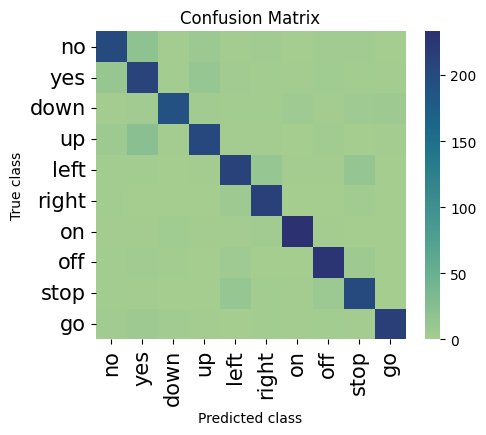

In [15]:
# plot confusion matrix
classes =  ['no', 'yes', 'down', 'up', 'left', 'right', 'on', 'off', 'stop', 'go']
confusion_matrix = torch.zeros(output_size, output_size)
with torch.no_grad():
    for i, (inputs, labels) in enumerate(val_loader):
        inputs = inputs.unsqueeze(1)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        for truth, predicted in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[truth.long(), predicted.long()] += 1

plt.figure(figsize=(5,4))
df_cm = pd.DataFrame(confusion_matrix, index=classes, columns=classes).astype(int)
heatmap = sns.heatmap(df_cm, cmap="crest")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='center',fontsize=15)
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title("Confusion Matrix")
plt.show()

# Super class classifier

In [21]:
super_classes =  ['directions', 'commands', 'binary_commands']
parent_dir = 'super_classes_all/'
file_dict = { 'wav_file' : [], 'class': [], 'fold':[]}

for i in super_classes:
    class_dir = parent_dir+i
    files = [class_dir + '/' + j for j in os.listdir(class_dir)]
    fold = [random.randint(1,10) for i in range(len(files))]
    file_dict['wav_file'] += files
    file_dict['class'] += [i]*len(files)
    file_dict['fold'] += fold
df= pd.DataFrame(file_dict)
print(df)
#print(file_dict)

{'wav_file': ['super_classes_all/directions/right_db8a3397_nohash_0.wav', 'super_classes_all/directions/left_0397ecda_nohash_1.wav', 'super_classes_all/directions/up_ec74a8a5_nohash_1.wav', 'super_classes_all/directions/down_6ef76186_nohash_3.wav', 'super_classes_all/directions/right_73af0c50_nohash_2.wav', 'super_classes_all/directions/up_5db0e146_nohash_0.wav', 'super_classes_all/directions/up_c5c60d8d_nohash_0.wav', 'super_classes_all/directions/down_3d6bee47_nohash_1.wav', 'super_classes_all/directions/right_0bde966a_nohash_0.wav', 'super_classes_all/directions/down_64220627_nohash_0.wav', 'super_classes_all/directions/up_8c3c4715_nohash_1.wav', 'super_classes_all/directions/up_611d2b50_nohash_4.wav', 'super_classes_all/directions/up_9886d8bf_nohash_2.wav', 'super_classes_all/directions/right_3f2b358d_nohash_0.wav', 'super_classes_all/directions/up_d197e3ae_nohash_2.wav', 'super_classes_all/directions/left_363c6bad_nohash_2.wav', 'super_classes_all/directions/down_7195ffa6_nohash_1

In [23]:
# extract features
features=[]
labels=[]
folds=[]
sr=16000
for i in range(len(df)):
    fold=df["fold"].iloc[i]
    path=df["wav_file"].iloc[i]
    label = df["class"].iloc[i]
    mfccs = extract_melspectrogram(path, sr)
    features.append(mfccs)
    folds.append(fold)
    labels.append(label)

le = LabelEncoder()
labels = le.fit_transform(labels)

In [24]:
features=torch.tensor(features)
labels=torch.tensor(labels)
folds=torch.tensor(folds)
# Saving the dataset to disk to prevent re-Loading
torch.save(features, "model_outputs/super_class_all_features_mfccs.pt")
torch.save(labels, "model_outputs/super_class_all_labels.pt")
torch.save(folds, "model_outputs/super_class_all_folds.pt")


In [16]:
# START RUNNING HERE
# load features for super class dataset
features=torch.load("model_outputs/super_class_all_features_mfccs.pt")#.to(device)
labels=torch.load("model_outputs/super_class_all_labels.pt")#.to(device)
folds=torch.load("model_outputs/super_class_all_folds.pt")#.to(device)

In [19]:
# initialize dataset
dataset=get_dataset(skip_fold=10)
# split data into training and validation sets
val_size=int(0.1*len(dataset))
train_size=len(dataset)-val_size
train_ds, val_ds=random_split(dataset, [train_size, val_size])

print("Number of training samples: ", len(train_ds))
print("Number of validation samples: ", len(val_ds))

# initialize data loader
batch_size=128
train_loader=DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader=DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)


Entire dataset size:  torch.Size([23682, 101, 40])
Number of training samples:  21314
Number of validation samples:  2368


In [21]:
# Instantiate the model, loss function, and optimizer
model = MyModel()
#model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
start_epoch = 0
end_epoch = 20
train_network(model, train_loader, val_loader, criterion, optimizer, start_epoch, end_epoch)
test_network(model, val_loader)


Epoch 0: model accuracy 57.31%
Epoch 1: model accuracy 67.10%
Epoch 2: model accuracy 71.07%
Epoch 3: model accuracy 75.30%
Epoch 4: model accuracy 76.94%
Epoch 5: model accuracy 80.79%
Epoch 6: model accuracy 83.02%
Epoch 7: model accuracy 83.23%
Epoch 8: model accuracy 83.74%
Epoch 9: model accuracy 86.23%
Epoch 10: model accuracy 87.29%
Epoch 11: model accuracy 87.08%
Epoch 12: model accuracy 87.96%
Epoch 13: model accuracy 87.96%
Epoch 14: model accuracy 88.60%
Epoch 15: model accuracy 88.51%
Epoch 16: model accuracy 88.22%
Epoch 17: model accuracy 88.09%
Epoch 18: model accuracy 89.02%
Epoch 19: model accuracy 89.86%
Test accuracy: 89 %


In [31]:
# save checkpoint
EPOCH = 20
PATH = "model_outputs/super_class_model.pt"

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, PATH)